# Word2vec in full documents

In [4]:
import logging
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [5]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Split corpus into sentences

In [10]:
import sklearn
data_tr = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="train")#["data"]
data_te = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="test")#["data"]

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    clean = clean.lower()
    words = clean.split()
    return words

In [12]:
sentences = []
for raw_sentence in data_tr["data"] + data_te["data"]:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [13]:
len(sentences)

18846

In [14]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 5,743,602 tokens


## Word2vec

### Train word2vec

In [15]:
num_features = 300
num_epochs   = 10

# Minimum word count threshold.
min_word_count = 0

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 5

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

seed = 1

#optional Training algorithm: 1 for skip-gram; otherwise CBOW
sg = 1


In [16]:
word2vec = w2v.Word2Vec(
    sg=sg,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling)

In [17]:
word2vec.build_vocab(sentences, keep_raw_vocab=True)

In [18]:
word2vec.corpus_count

18846

In [19]:
word2vec.vocabulary

In [20]:
len(word2vec.vocabulary.raw_vocab)

115065

In [21]:
total_examples = len(sentences)
total_examples

18846

In [22]:
%%time
word2vec.train(sentences,
               epochs = num_epochs,
               total_examples=total_examples)

CPU times: user 11min 25s, sys: 2.35 s, total: 11min 27s
Wall time: 1min 35s


(46280943, 57436020)

In [28]:
foldername = "../saved_models/" + "w2v_" + str(num_features) +"features_10epochs"
modelname  = "word2vec_" + str(num_features) +"features" + str(num_epochs)+"epochs.w2v"

if not os.path.exists(foldername):
    os.makedirs(foldername)
    word2vec.save(os.path.join(foldername, modelname))
else:
    print("folder {} already exists".format(foldername))
    

### inspect words

In [29]:
words = list(word2vec.wv.vocab)
vectors = list(word2vec.wv.vectors)

In [30]:
len(words)

115065

## Predicting from a Word2vec averaged representation

In [31]:
import sklearn
data_tr = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="train")
data_te = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="test")

In [32]:
from sklearn.linear_model import LogisticRegressionCV
word2vec.wv.get_vector("house").shape

(300,)

In [33]:
def doc_to_vec(sentence, word2vec):
    word_list    = sentence_to_wordlist(sentence)
    word_vectors = []
    for w in word_list:
        word_vectors.append(word2vec.wv.get_vector(w))

    return np.mean(word_vectors,axis=0)

In [34]:
vec = doc_to_vec(data_tr["data"][0], word2vec)
vec.shape, len(data_tr["data"])

((300,), 11314)

In [35]:
X_tr = np.zeros((len(data_tr["data"]), 300))
y_tr = data_tr["target"]
n_samples = X_tr.shape[0]

for i in range(n_samples):
    X_tr[i,:] = doc_to_vec(data_tr["data"][i], word2vec)

X_te = np.zeros((len(data_te["data"]), 300))
y_te = data_te["target"]
n_samples = X_te.shape[0]
for i in range(n_samples):
    X_te[i,:] = doc_to_vec(data_te["data"][i], word2vec)

### Predicting with a Logistic Regression 

In [37]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_tr, y_tr)

/Users/davidbuchaca1/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/davidbuchaca1/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [41]:
X_tr.shape, X_te.shape

((11314, 300), (7532, 300))

In [40]:
y_pred = logreg.predict(X_tr)
print('Train accuracy for movie plots: {}'.format(accuracy_score(y_tr, y_pred)))
print('Train F1 score for movie plots: {}'.format(f1_score(y_tr, y_pred, average='weighted')))

y_pred = logreg.predict(X_te)
print('Test accuracy for movie plots: {}'.format(accuracy_score(y_te, y_pred)))
print('Test F1 score for movie plots: {}'.format(f1_score(y_te, y_pred, average='weighted')))

Train accuracy for movie plots0.9394555418066113
Train F1 score for movie plots: 0.9392440455365525
Test accuracy for movie plots0.7365905469994689
Test F1 score for movie plots: 0.7379816450290826


### Predicting with a MLP

In [42]:
X_tr.shape, X_te.shape

((11314, 300), (7532, 300))

In [43]:
from sklearn import neural_network

clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[100])
clf.fit(X_tr, y_tr)

/Users/davidbuchaca1/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[300], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [45]:
y_pred = clf.predict(X_tr)
print('Train accuracy for movie plots: {}'.format(accuracy_score(y_tr, y_pred)))
print('Train F1 score for movie plots: {}'.format(f1_score(y_tr, y_pred, average='weighted')))

y_pred = clf.predict(X_te)
print('Test accuracy for movie plots: {}'.format(accuracy_score(y_te, y_pred)))
print('Test F1 score for movie plots: {}'.format(f1_score(y_te, y_pred, average='weighted')))

Train accuracy for movie plots0.9795828177479229
Train F1 score for movie plots: 0.9795884693543918
Test accuracy for movie plots0.7895645246946362
Test F1 score for movie plots: 0.7887611372446388


## Predicting from a count matrix appended with word2vec features 

In [50]:
os.listdir("../saved_models/")

['.DS_Store',
 'w2v_5000features_10epochs',
 'w2v_2000features_10epochs',
 'w2v_600features_10epochs',
 'w2v_300features_10epochs']

In [51]:
os.listdir("../saved_models/w2v_300features_10epochs/")

['word2vec_300features10epochs.w2v.wv.vectors.npy',
 'word2vec_300features10epochs.w2v',
 'word2vec_300features10epochs.w2v.trainables.syn1neg.npy']

In [57]:
foldername = "../saved_models/w2v_300features_10epochs"
modelname  = "word2vec_300features10epochs.w2v"
word2vec   = w2v.Word2Vec.load(os.path.join(foldername, modelname))

In [95]:
X_train = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="train")["data"]
X_test  = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="test")["data"]
len(X_train), len(X_test)

(11314, 7532)

In [96]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()

X_train = count_vectorizer.fit_transform(X_train)
X_test  = count_vectorizer.transform(X_test) 

In [99]:
from sklearn.pipeline import FeatureUnion
import scipy

X_tr_extended = scipy.sparse.hstack((X_tr, X_train))
X_te_extended = scipy.sparse.hstack((X_te, X_test))

### Using a Logistic Regression

In [104]:
%%time
clf_logit_ext = sklearn.linear_model.LogisticRegression()

clf_logit_ext.fit(X_tr_extended, y_tr)
y_pred = clf_logit_ext.predict(X_tr_extended)
print('Train accuracy for movie plots: {}'.format(accuracy_score(y_tr, y_pred)))
print('Train F1 score for movie plots: {}'.format(f1_score(y_tr, y_pred,
                                                           average='weighted')))

y_pred = clf_logit_ext.predict(X_te_extended)
print('Test accuracy for movie plots: {}'.format(accuracy_score(y_te, y_pred)))
print('Test F1 score for movie plots: {}'.format(f1_score(y_te, y_pred,
                                                          average='weighted')))


/Users/davidbuchaca1/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/davidbuchaca1/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train accuracy for movie plots0.999734841788934
Train F1 score for movie plots: 0.9997348419755528
Test accuracy for movie plots0.8112055231014339
Test F1 score for movie plots: 0.8103034177382152
CPU times: user 1min 7s, sys: 378 ms, total: 1min 8s
Wall time: 1min 8s


### Using a MLP

In [101]:
%%time
clf_mlp_ext = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[100],
                                                   validation_fraction=0.1 )
clf_mlp_ext.fit(X_tr_extended, y_tr)
y_pred = clf_mlp_ext.predict(X_tr_extended)
print('Train accuracy for movie plots%s' % accuracy_score(y_tr, y_pred))
print('Train F1 score for movie plots: {}'.format(f1_score(y_tr, y_pred, 
                                                           average='weighted')))

y_pred = clf_mlp_ext.predict(X_te_extended)
print('Test accuracy for movie plots: {}'.format(accuracy_score(y_te, y_pred)))
print('Test F1 score for movie plots: {}'.format(f1_score(y_te, y_pred,
                                                          average='weighted')))



Train accuracy for movie plots0.999734841788934
Train F1 score for movie plots: 0.9997348426792321
Test accuracy for movie plots0.831651619755709
Test F1 score for movie plots: 0.8317547230992746
CPU times: user 23min 8s, sys: 3min 33s, total: 26min 41s
Wall time: 14min 59s


## Appending word2vec and using ngrams

In [109]:
foldername = "../saved_models/" + "w2v_" + str(num_features) +"features_10epochs"
modelname  = "word2vec_" + str(num_features) +"features" + str(num_epochs)+"epochs.w2v"

word2vec = w2v.Word2Vec.load(os.path.join(foldername, modelname))
n_features = word2vec.trainables.layer1_size

In [112]:
X_tr = np.zeros((len(data_tr["data"]), n_features))
y_tr = data_tr["target"]
n_samples = X_tr.shape[0]

for i in range(n_samples):
    X_tr[i,:] = doc_to_vec(data_tr["data"][i], word2vec)

X_te = np.zeros((len(data_te["data"]), n_features))
y_te = data_te["target"]
n_samples = X_te.shape[0]
for i in range(n_samples):
    X_te[i,:] = doc_to_vec(data_te["data"][i], word2vec)

In [122]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,2))

X_train = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="train")["data"]
X_test  = sklearn.datasets.twenty_newsgroups.fetch_20newsgroups(subset="test")["data"]

X_train = count_vectorizer.fit_transform(X_train)
X_test  = count_vectorizer.transform(X_test)

In [123]:
X_tr_extended = scipy.sparse.hstack((X_tr, X_train))
X_te_extended = scipy.sparse.hstack((X_te, X_test))

In [126]:
%%time
clf_mlp_ext_ngram = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[200],
                                                         validation_fraction=0.1 )

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 15 µs


In [ ]:
clf_mlp_ext_ngram.fit(X_tr_extended, y_tr)

y_pred = clf_mlp_ext_ngram.predict(X_tr_extended)
print('Train accuracy for movie plots: {}'.format(accuracy_score(y_tr, y_pred)))
print('Train F1 score for movie plots: {}'.format(f1_score(y_tr, y_pred,
                                                           average='weighted')))

y_pred = clf_mlp_ext_ngram.predict(X_te_extended)
print('Test accuracy for movie plots: {}'.format(accuracy_score(y_te, y_pred)))
print('Test F1 score for movie plots: {}'.format(f1_score(y_te, y_pred,
                                                          average='weighted')))




# More  document features


We will denote by

- $W= \{w_1, \dots, w_D\}$ the set of words used to make the representations.
- $X$ our corpus of documents.
- $X_w$ the set of documents that contain word $w$. 

### Bag of words vector  (or `tf` vector)


- The bag of words representation for a document $x$ given a vocabulary $W$, or the term frequency vector **$\text{tf}(X;W)$** is defined as 

$$
\text{tf}(x;W) = \left( \#\{w_1| w_1 \in x\}, \dots, \#\{w_D| w_D \in x\})\right)
$$



### Term frequency Inverse Document frequency ( `tf * idf`)

The objective of tf-idf representation is to emphasize the most relevant words of the documents. We want to emphasize:

- Words that appear **frequently in the document**: term frequency 
- Words that appear **rarely in the corpus**: inverse document frequency

#### Definition of the feature vectors


- The **$\text{tf}(X;W)$** vector for a document $x$ is defined as 

$$
\text{tf}(x;W) = \left( \#\{w_1| w_1 \in x\}, \dots, \#\{w_D| w_D \in x\})\right)
$$

- The **$\text{idf}(W; X)$** vector is defined as 

**$$\text{idf}(W; X) = \left( \text{idf}(w_1; X), \dots, \text{idf}(w_D; X)\right)$$** 
   
$\,\,\,\,\,\,\,$ A component of the feature for word $w \in W$ in the corpus $X$ is defined as 

$$
\text{idf}(w, X) = log\left(\frac{|X|}{1+|X_{w}|}\right)
$$

$\,\,\,\,\,\,\,$Which simply means the full vector is 
$$
\text{idf}(w, X) = \left( log\left(\frac{|X|}{1+|X_{w_1}|}\right), \dots, log\left(\frac{|X|}{1+|X_{w_D}|}\right) \right)
$$

- The tfidf vector for a document $x$ will be: $tf(x; X) * idf(X)$

#### Observations

- If a word appears in a few documents the idf vector will increase its weight.

- If a word appears in a lots of documents documents the idf vector will decrease its weight.

#### `sklearn.feature_extraction.text.TfidfVectorizer`

- Notice that the implementation in sklearn already prevents zero divisions by default. This happens if `smooth_idf=True`.

- By default the tfidf will only use words since `ngram_range=(1, 1)`. But this can be changed to allow n-grams in the feature vector components.

#### Example

Let us assume we have a corpus with one milion documents

- Consider a word appearping in 100 documents:

$$\log\left(\frac{1000.000}{1 + 100} \right) = 9.200$$

- Consider a word appearing in 100.000 documents

$$\log\left(\frac{1000.000}{1 + 100.000} \right) = 2.197$$



In [138]:
import scipy as sp

def build_vocabulary(corpus, splitter):
    """
    This function has to return X_w, a dict containing for each key, how
    many documents having that key are in our corpus.
    """
    vocabulary = set()
    X_w = dict()
    
    for document in corpus:
        words      = set(splitter.findall(document.lower()))
        # fill up vocabulary 
        
        # fill up X_w
        
    return vocabulary, X_w

def term_frequency(document, word_to_ind, splitter, 
                   normalize=True, word_inds=False):
    
    words = splitter.findall(document.lower())
    n_features = len(word_to_ind)
    tf = sp.sparse.lil_matrix( (1, n_features), dtype=float)
    
    word_indices = []
    for w in words:
        ## fill up word_indices
        
        ## fill up tf
        
        
    if word_inds:
        if normalize:
            return tf.multiply(1/sp.sparse.linalg.norm(tf))
        else:
            return tf
    else:
        if normalize:
            return tf.multiply(1/sp.sparse.linalg.norm(tf))
        else:
            return tf

In [139]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [140]:
splitter = re.compile('(?u)\\b\\w\\w+\\b')
%time vocabulary, X_w = build_vocabulary(newsgroups_train.data, splitter)

word_to_ind = {v:i for i,v in enumerate(vocabulary)}
ind_to_word = {v:k for k,v in word_to_ind.items()}

CPU times: user 24.9 s, sys: 96 ms, total: 25 s
Wall time: 25 s


In [141]:
%time tf = term_frequency(newsgroups_train.data[0],\
                          word_to_ind, splitter, word_inds=False)

CPU times: user 1.45 ms, sys: 300 µs, total: 1.75 ms
Wall time: 1.44 ms


## Verify that the term frequency is OK, compare with sklearn

In [142]:
tfidf_sk = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=False,
                                                           smooth_idf=False, 
                                                           sublinear_tf=False)

%time tfidf_sk.fit(newsgroups_train.data)

inverse_vocabulary_ = {v: k for k, v in tfidf_sk.vocabulary_.items()}

CPU times: user 2.08 s, sys: 43.4 ms, total: 2.12 s
Wall time: 2.13 s


In [143]:
%time x_sk = tfidf_sk.transform([newsgroups_train.data[0]])

CPU times: user 321 µs, sys: 6 µs, total: 327 µs
Wall time: 327 µs


In [144]:
np.isclose(tf.sum(), x_sk.sum())

True

In [145]:
words_x_own = [ind_to_word[k] for k in tf.nonzero()[1]]
words_x_sk = [inverse_vocabulary_[k] for k in x_sk.nonzero()[1]]
set(words_x_own) == set(words_x_sk)

True

## Generate tfidf and compare with sklearn 


In [146]:
def compute_idf(X_w, word_to_ind, n_documents):

    n_features = len(word_to_ind)
    #idf = sp.sparse.csr_matrix( (1, n_features), dtype=float)
    idf = np.zeros([1, n_features])
    
    for w in X_w:
        # fill up idf
        pass
    
    #idf = idf + 1    
    return sp.sparse.csr_matrix(idf)

In [147]:
%%time 
# lil_matrix is more efficient.
tf = term_frequency(newsgroups_train.data[0], word_to_ind,\
                    splitter, normalize=False,word_inds=False)

idf = compute_idf(X_w,word_to_ind, len(newsgroups_train.data))

CPU times: user 178 ms, sys: 1.41 ms, total: 179 ms
Wall time: 178 ms


In [148]:
idf.max(), idf.min()

(9.640737377507692, 1.0)

In [149]:
n_documents = len(X_w)

In [150]:
tfidf = tf.multiply(idf)
tfidf = tfidf/sp.sparse.linalg.norm(tfidf)
sp.sparse.linalg.norm(tfidf)

1.0

In [151]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()
tfidf_vectorizer.fit(newsgroups_train.data);

In [153]:
tfidf_sklearn = tfidf_vectorizer.transform(newsgroups_train.data[0:1])

In [154]:
tfidf.data.dtype, tfidf_sklearn.data.dtype

(dtype('float64'), dtype('float64'))

In [158]:
print(tfidf.sum(), tfidf_sklearn.sum())
print("\nsklearn tfidf and our tfidf are the same:",
      np.isclose(tfidf_sklearn.sum(),tfidf.sum()))

7.697815233022508 7.697815233022508

sklearn tfidf and our tfidf are the same: True


# tfidf in data 

In [276]:
people = pd.read_csv('../data/people_wiki.csv')

In [ ]:
people.loc[0:40000].to_csv()

In [253]:
people.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [254]:
people.dtypes

URI     object
name    object
text    object
dtype: object

In [255]:
people["text"][3]

'franz rottensteiner born in waidmannsfeld lower austria austria on 18 january 1942 is an austrian publisher and critic in the fields of science fiction and the fantasticrottensteiner studied journalism english and history at the university of vienna receiving his doctorate in 1969 he served about fifteen years as librarian and editor at the sterreichisches institut fr bauforschung in vienna in addition he produced a number of translations into german of leading sf authors including herbert w franke stanislaw lem philip k dick kobo abe cordwainer smith brian w aldiss and the strugatski brothersin 1973 his new york anthology view from another shore of european science fiction introduced a number of continental authors to the englishreading public some of the authors in the work are stanislaw lem josef nesvadba gerard klein and jeanpierre andrevonthe year 1975 saw the start of his series die phantastischen romane for seven years it republished works of both lesser and betterknown writers

In [256]:
obama = people[people['name'] == 'Barack Obama']

In [257]:
people[people['name'] == 'Barack Obama']["text"]

35817    barack hussein obama ii brk husen bm born augu...
Name: text, dtype: object

In [258]:
def get_text(df, boolean_series):
    row_df = df[boolean_series].text
    return df.loc[row_df.index[0]].text

def get_text_given_name(df, name):
    row_df = df[df["name"] == name]
    return df.loc[row_df.index[0]].text


In [259]:
get_text_given_name(people, "Barack Obama")

'barack hussein obama ii brk husen bm born august 4 1961 is the 44th and current president of the united states and the first african american to hold the office born in honolulu hawaii obama is a graduate of columbia university and harvard law school where he served as president of the harvard law review he was a community organizer in chicago before earning his law degree he worked as a civil rights attorney and taught constitutional law at the university of chicago law school from 1992 to 2004 he served three terms representing the 13th district in the illinois senate from 1997 to 2004 running unsuccessfully for the united states house of representatives in 2000in 2004 obama received national attention during his campaign to represent illinois in the united states senate with his victory in the march democratic party primary his keynote address at the democratic national convention in july and his election to the senate in november he began his presidential campaign in 2007 and afte

In [260]:
import sklearn
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()

In [261]:
obama_vec, emma_vec = tfidf.fit_transform([get_text_given_name(people, "Barack Obama"), 
                                           get_text_given_name(people, "Emma Watson")])

In [262]:
%%time
X_tfidf = tfidf.fit_transform(people["text"])

CPU times: user 12 s, sys: 233 ms, total: 12.3 s
Wall time: 12.3 s


In [263]:
import numpy as np
import scipy as scp
from sklearn.metrics.pairwise import cosine_similarity

In [264]:
brad_pitt_tfidf = tfidf.transform([get_text_given_name(people, "Brad Pitt")])
angelina_tfidf  = tfidf.transform([get_text_given_name(people, "Angelina Jolie")])
obama_tfidf     = tfidf.transform([get_text_given_name(people, "Barack Obama")])
bill_tfidf      = tfidf.transform([get_text_given_name(people, "Bill Clinton")])
emma_tfidf      = tfidf.transform([get_text_given_name(people, "Emma Watson")])

In [265]:
def get_closest_k_names(tfidf_vec, X_tfidf, k=10):
    aux = np.argsort(cosine_similarity(tfidf_vec, X_tfidf))
    return people["name"][aux[0][-k-1:-1]]

In [266]:
get_closest_k_names(emma_tfidf, X_tfidf, k=10)

47793           Miranda Richardson
40216               Carolyn Watson
11666                   Jane Fonda
34756                 Maggie Smith
35902            Natashia Williams
8973                  John Granger
17821                Emma Thompson
46781                 Lilla Watson
53752    Patrick Watson (producer)
3115                  Stuart Craig
Name: name, dtype: object

In [267]:
get_closest_k_names(bill_tfidf, X_tfidf, k=10)

54452         George H. W. Bush
35817              Barack Obama
54499        Kris M. Balderston
2092         Richard Blumenthal
54062           James A. Joseph
28447            George W. Bush
52859                 Ann Lewis
4096           Sheffield Nelson
25658               Dick Morris
57108    Hillary Rodham Clinton
Name: name, dtype: object

In [268]:
get_closest_k_names(angelina_tfidf, X_tfidf, k=10)

24426             Brad Pitt
51145          Kate Winslet
21644          Jodie Foster
44571        Candice Bergen
16242          Meryl Streep
54362    Konkona Sen Sharma
44992        Julianne Moore
34756          Maggie Smith
57434           Glenn Close
29009       Barbara Hershey
Name: name, dtype: object

# Finding similar documents

In [159]:
def closest_point(all_points, query_point, dist):
    closest_point_    = None
    closest_distance_ = np.inf
    
    for current_point in all_points:
        current_distance = dist(query_point, current_point)
        
        if  current_distance < closest_distance_:
            closest_distance_ = current_distance
            closest_point_    = current_point
            
    return closest_point_, closest_distance_

def dist(x,y):
    return np.sqrt(np.linalg.norm((x-y)**2))

Query: [1 3]
Closest to query: [0 3]


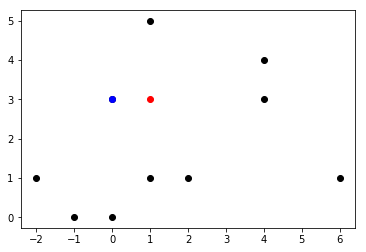

In [160]:

X = np.array([[1,1],[0,3],[4,3],[0,0],[1,5],[6,1],[-2,1],[4,4],[2,1],[-1,0]])
x_components = [x[0] for x in X]
y_components = [x[1] for x in X]
query = np.array([1,3])

closest_to_query, _ = closest_point(X, query, dist)
print("Query: {}\nClosest to query: {}".format(query,closest_to_query))
plt.scatter(x_components, y_components, color="black")
plt.scatter(query[0], query[1], color="red")
plt.scatter(closest_to_query[0], closest_to_query[1], color="blue", linewidths=1, marker="o")

## Finding closest point in numpy

In [221]:
import sklearn
from sklearn import neighbors

n_features = 20
X = np.random.rand(10_000_000,n_features).astype(np.float32)
x = np.random.rand(1,n_features).astype(np.float32)

In [222]:
%time distances =  np.mean((X-x)**2,1)
#One second is too much
%time closest = np.argmin(np.mean((X-x)**2,1))
print("\nclosest row from x is {}".format(closest))

CPU times: user 441 ms, sys: 173 ms, total: 614 ms
Wall time: 614 ms
CPU times: user 430 ms, sys: 176 ms, total: 606 ms
Wall time: 606 ms

closest row from x is 6692578


In [223]:
distances[closest]

0.02051361

In [224]:
np.argsort(distances)

array([6692578, 6444021, 5730515, ..., 1365964, 4872855, 9615531])

In [234]:
s = time.time()
closest = np.argmin(np.mean((X-x)**2,1))
e = time.time()
numpy_time = abs(s-e)

## Custom function for closest point

In [165]:
%%time
closest_point_, closest_distance_ = closest_point(X, x, dist)

CPU times: user 1min 2s, sys: 434 ms, total: 1min 3s
Wall time: 1min 3s


## Use Kd tree

KD-trees are an efficient structure for efficiently representing our data. KD-trees provide an organization of our documents in terms of a certain partitioning of our space. The organization is based on recursively partitioning points into axis, defining "boxes".

The KD-tree structure is based on making aligned cuts and maintaining lists of points that fall into each one of these different bins. This structure allows us  efficiently prune our search space so that we do not have to visit every single data point, for every query, necessarily. Sometimes we will have to do it but hopefully, in many cases, we will not have to do it.


#### Using KD-trees

Let us see how KD-trees can aid in efficiently making NN search. Let us assume we are given a KD_tree and let us see how to ue it. Later on we will see how to build the tree.

Given a query point $\bf{x}$:

- Traverse the tree until the query point is reached. That is, check all the conditions of the KD-tree for the query point until a leave is reached.
    - Once the query point is found save the "box" where it is found.
    
    
- Compute the distance between each neighbor in the box and the query point.


- Record the smallest distance to the NN so far.


- Backtrack and try other branch at each node visited.
    - Use the distance bound and bounding box of each node to prune parts of the three that cannot include the nearest neighbor.
         
         That is, **if the smallest distance is less than the distance from the query point to the bounding box there is no need to compute the distance between any point in the bounding box to the query point**.

In [226]:
%%time
tree = sklearn.neighbors.KDTree(X, leaf_size=1_000)

CPU times: user 36.1 s, sys: 450 ms, total: 36.5 s
Wall time: 36.5 s


In [227]:
%%time 
s = time.time()
distance_to_closest, closest_kdtree = tree.query(x, k=1)
e = time.time()
kdtree_time = abs(s-e)

CPU times: user 285 ms, sys: 1.08 ms, total: 286 ms
Wall time: 286 ms


In [228]:
print("\nclosest row from x is {}".format(closest_kdtree[0][0]))


closest row from x is 6692578


Notice the difference:

In [229]:
print("Numpy time:", numpy_time)
print("Kdtree time:", kdtree_time)

Numpy time: 0.6174180507659912
Kdtree time: 0.2856941223144531


### building a kdtree with less leaves

leaf_size : positive integer (default = 40)

Number of points at which to switch to brute-force. Changing leaf_size will not affect the results of a query, but can significantly impact the speed of a query and the memory required to store the constructed tree.

The amount of memory needed to store the tree scales as approximately n_samples / leaf_size. For a specified leaf_size, a leaf node is guaranteed to satisfy leaf_size <= n_points <= 2 * leaf_size, except in the case that n_samples < leaf_size.

In [230]:
%%time
tree = sklearn.neighbors.KDTree(X, leaf_size=10)

CPU times: user 39.2 s, sys: 557 ms, total: 39.7 s
Wall time: 39.8 s


In [231]:
%%time 
s = time.time()
distance_to_closest, closest_kdtree = tree.query(x, k=1)
e = time.time()
kdtree_time2 = abs(s-e)

CPU times: user 80.3 ms, sys: 901 µs, total: 81.2 ms
Wall time: 80.2 ms


In [232]:
print("\nclosest row from x is {}".format(closest_kdtree[0][0]))


closest row from x is 6692578


In [233]:
print("Numpy time:", numpy_time)
print("Kdtree(1000) time:", kdtree_time)
print("Kdtree(10)   time:", kdtree_time2)

Numpy time: 0.6174180507659912
Kdtree(1000) time: 0.2856941223144531
Kdtree(10)   time: 0.08020997047424316


We can use also the kd tree to get the k closest items to our query vector 

In [235]:
%time distances_to_closest, close_kdtree = tree.query(x,k=10)

CPU times: user 176 ms, sys: 1.18 ms, total: 177 ms
Wall time: 176 ms
